In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [4]:
n =  30254 #novel number
t = 'romance_of_lust'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [5]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [6]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [7]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [8]:
df_novel.head()

,0
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...
1,"I was approaching fifteen, Mary was about a ye..."
2,"Mamma treated us all as children, and was blin..."
3,"Although not tall for my age, nor outwardly pr..."
4,"As yet, I had absolutely no knowledge of the u..."


Create the wrd_length and total_char columns.

In [9]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [10]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [11]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [12]:
df_novel.head()

,0,wrd_length,total_char
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64


Create syllable count column

In [13]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [14]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [15]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [16]:
df_novel['syl_count'] = syl_count_arr

In [17]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,"[2, 1, 2, 0, 2, 2, 0, 2, 0, 4, 1, 0, 3, 1, 3, ..."
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,"[1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, ..."
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,"[2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,"[2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 2, 1, ..."
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,"[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1]"


In [18]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [19]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [20]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [21]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [22]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Create cluster dataframe - remove columns that can't be used

In [23]:
df_cluster = df_novel.drop('wrd_length', 1)

In [24]:
df_cluster = df_cluster.drop('syl_count', 1)

In [25]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000
2,"Mamma treated us all as children, and was blin...",75,25,-0.500
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050


Create 20 clusters on scaled data

In [26]:
X = df_cluster.drop(0, axis=1)

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [29]:
df_cluster_20 = df_cluster.copy()

In [30]:
df_cluster_20['cluster'] = km.labels_

In [31]:
df_cluster_20.head()

,0,total_char,syl_sum,sentiment,cluster
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000,10
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000,10
2,"Mamma treated us all as children, and was blin...",75,25,-0.500,17
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325,16
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050,6


In [32]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000
2,"Mamma treated us all as children, and was blin...",75,25,-0.500
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050


In [33]:
df_cluster_20.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,165.769697,53.086869,0.218417
1,21.628231,6.940358,0.000497
2,45.309211,14.513158,0.557701
3,111.703259,35.833619,0.260540
4,421.425000,134.387500,0.181202
5,94.110312,30.585132,0.498983
6,64.296371,20.533266,0.001854
7,56.183544,17.753165,-0.231809
8,163.751208,52.137681,-0.040894


In [34]:
centers = df_cluster_20.groupby('cluster').mean()

Create Scatter plot 

In [35]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

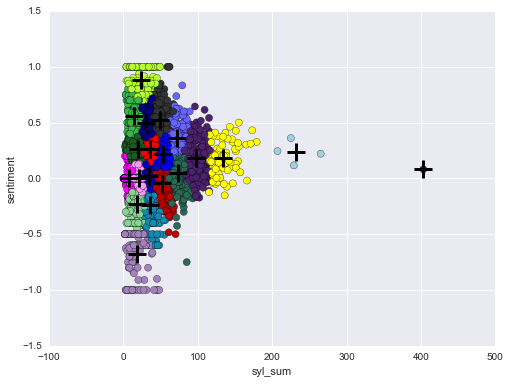

In [36]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster_20.syl_sum, df_cluster_20.sentiment, c=colors[df_cluster_20.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Add cluster_20 to original dataframe

In [37]:
df_novel['cluster_20'] = df_cluster_20['cluster']

In [38]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,"[2, 1, 2, 0, 2, 2, 0, 2, 0, 4, 1, 0, 3, 1, 3, ...",39,0.000,10
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,"[1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, ...",31,0.000,10
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,"[2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",25,-0.500,17
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,"[2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 2, 1, ...",78,0.325,16
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,"[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1]",24,-0.050,6


Create 3 clusters

In [39]:
df_cluster_3 = df_cluster.copy()

In [40]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000
2,"Mamma treated us all as children, and was blin...",75,25,-0.500
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050


In [41]:
X = df_cluster_3.drop(0, axis=1)

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [44]:
df_cluster_3['cluster'] = km.labels_

In [45]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,66.107283,21.127121,-0.035074
1,222.607009,71.311014,0.166148
2,94.689655,30.471575,0.458041


In [46]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000,0
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000,0
2,"Mamma treated us all as children, and was blin...",75,25,-0.500,0
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325,1
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050,0


Add cludter_3 to original dataframe

In [47]:
df_novel['cluster_3_syl'] = df_cluster_3['cluster']

In [48]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,"[2, 1, 2, 0, 2, 2, 0, 2, 0, 4, 1, 0, 3, 1, 3, ...",39,0.000,10,0
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,"[1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, ...",31,0.000,10,0
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,"[2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",25,-0.500,17,0
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,"[2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 2, 1, ...",78,0.325,16,1
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,"[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1]",24,-0.050,6,0


Create 3 Clusters with no syl_sum

In [49]:
df_cluster_3no_syl = df_cluster.copy()

In [50]:
df_cluster_3no_syl = df_cluster.drop('syl_sum', 1)

In [51]:
X = df_cluster_3no_syl.drop(0, axis=1)

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [54]:
df_cluster_3no_syl['cluster'] = km.labels_

In [55]:
df_cluster_3no_syl.head()

,0,total_char,sentiment,cluster
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,0.000,0
1,"I was approaching fifteen, Mary was about a ye...",88,0.000,0
2,"Mamma treated us all as children, and was blin...",75,-0.500,0
3,"Although not tall for my age, nor outwardly pr...",225,0.325,2
4,"As yet, I had absolutely no knowledge of the u...",64,-0.050,0


In [56]:
df_cluster_3no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,68.896061,-0.035146
1,93.151196,0.472764
2,223.480645,0.170526


Add cluster_3no_syl to original dataframe

In [57]:
df_novel['cluster_3no_syl'] = df_cluster_3no_syl['cluster']

In [58]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,"[2, 1, 2, 0, 2, 2, 0, 2, 0, 4, 1, 0, 3, 1, 3, ...",39,0.000,10,0,0
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,"[1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, ...",31,0.000,10,0,0
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,"[2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",25,-0.500,17,0,0
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,"[2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 2, 1, ...",78,0.325,16,1,2
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,"[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1]",24,-0.050,6,0,0


Create 5 Clusters

In [59]:
df_cluster_5 = df_cluster.copy()

In [60]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,120,39,0.000
1,"I was approaching fifteen, Mary was about a ye...",88,31,0.000
2,"Mamma treated us all as children, and was blin...",75,25,-0.500
3,"Although not tall for my age, nor outwardly pr...",225,78,0.325
4,"As yet, I had absolutely no knowledge of the u...",64,24,-0.050


In [61]:
X = df_cluster_5.drop(0, axis=1)

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [64]:
df_cluster_5['cluster'] = km.labels_

In [65]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,116.818598,37.317073,0.026767
1,199.192126,64.000000,0.228480
2,83.011628,26.764858,0.527847
3,355.594488,113.464567,0.171459
4,43.586193,13.930178,-0.035272


Add cluster_5 to original dataframe

In [66]:
df_novel['cluster_5'] = df_cluster_5['cluster']

In [67]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,"[2, 1, 2, 0, 2, 2, 0, 2, 0, 4, 1, 0, 3, 1, 3, ...",39,0.000,10,0,0,0
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,"[1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, ...",31,0.000,10,0,0,0
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,"[2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",25,-0.500,17,0,0,4
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,"[2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 2, 1, ...",78,0.325,16,1,2,1
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,"[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1]",24,-0.050,6,0,0,4


Write files to csv

In [68]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [69]:
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [70]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,CONTENTS The Novice--Mrs. Benson--Mary--Mrs. ...,"[8, 3, 6, 3, 6, 4, 3, 6, 2, 14, 4, 3, 7, 4, 6,...",120,[2 1 2 0 2 2 0 2 0 4 1 0 3 1 3 3 1 1 1 1 1 2 3...,39,0.000,10,0,0,0
1,"I was approaching fifteen, Mary was about a ye...","[1, 3, 11, 7, 4, 3, 5, 1, 4, 7, 3, 5, 7, 6, 3,...",88,[1 1 3 2 2 1 2 1 2 2 1 3 2 1 1 2 2 1 1],31,0.000,10,0,0,0
2,"Mamma treated us all as children, and was blin...","[5, 7, 2, 3, 2, 8, 3, 3, 5, 2, 3, 4, 4, 1, 3, ...",75,[2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1],25,-0.500,17,0,0,4
3,"Although not tall for my age, nor outwardly pr...","[8, 3, 4, 3, 2, 3, 3, 9, 10, 1, 5, 10, 2, 8, 4...",225,[2 1 1 1 1 1 1 3 3 1 2 4 1 2 1 4 1 1 3 3 1 1 1...,78,0.325,16,1,2,1
4,"As yet, I had absolutely no knowledge of the u...","[2, 3, 1, 3, 10, 2, 9, 2, 3, 4, 2, 3, 9, 6, 2, 3]",64,[1 1 1 1 5 1 2 1 1 1 1 1 3 2 1 1],24,-0.050,6,0,0,4


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [71]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
7570,At the third time I shall suck thy breasts wit...,"[2, 3, 5, 4, 1, 5, 4, 3, 7, 4, 4, 7, 4, 3, 4, ...",159,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, ...",52,-0.025,8,1,2,0
7571,"That will last until half-past two o'clock, th...","[4, 4, 4, 5, 9, 3, 7, 4, 2, 5, 5, 8, 4, 5, 5, ...",153,"[1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, ...",47,0.000,8,1,0,0
7572,"Behold, the following part shall come to you i...","[6, 3, 9, 4, 5, 4, 2, 3, 2, 3, 12, 7, 3]",63,"[2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1]",20,0.000,6,0,0,4
7573,Mem.,[3],3,[1],1,0.000,1,0,0,4
7574,"The commission herein is returnable in Paris, ...","[3, 10, 6, 2, 10, 2, 5, 4, 4, 4]",50,"[1, 3, 2, 1, 3, 1, 2, 0, 1, 0]",14,0.000,6,0,0,4


In [72]:
df_novel['total_char'].sum()

812187

In [73]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - (.06 * (int(len(df_novel) - 1)))
# or figure out some better code. 
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [74]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:428]
df_novel['total_char'][428:817]
df_novel['total_char'][817:1205]
df_novel['total_char'][1205:1614]
df_novel['total_char'][1614:1969]
df_novel['total_char'][1969:2310]
df_novel['total_char'][2310:2652]
df_novel['total_char'][2652:2984]
df_novel['total_char'][2984:3325]
df_novel['total_char'][3325:3736]
df_novel['total_char'][3736:4134]
df_novel['total_char'][4134:4513]
df_novel['total_char'][4513:4939]
df_novel['total_char'][4939:5334]
df_novel['total_char'][5334:5781]
df_novel['total_char'][5781:6159]
df_novel['total_char'][6159:6457]
df_novel['total_char'][6457:6797]
df_novel['total_char'][6797:7148]
df_novel['total_char'][7148:7512]


In [75]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
428
0.111907476034
428
817
0.145669904371
817
1205
0.165901256701
1205
1614
0.145599614958
1614
1969
0.137305547874
1969
2310
0.140512718729
2310
2652
0.169517152578
2652
2984
0.163110134239
2984
3325
0.150091196263
3325
3736
0.159102663604
3736
4134
0.143652568224
4134
4513
0.153976586722
4513
4939
0.157790702784
4939
5334
0.140812802765
5334
5781
0.114262534535
5781
6159
0.133966238662
6159
6457
0.189971106234
6457
6797
0.182211340951
6797
7148
0.155745577244
7148
7512
0.104732651331


In [76]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.11190748  0.1456699   0.16590126  0.14559961  0.13730555  0.14051272
  0.16951715  0.16311013  0.1500912   0.15910266  0.14365257  0.15397659
  0.1577907   0.1408128   0.11426253  0.13396624  0.18997111  0.18221134
  0.15574558  0.10473265]


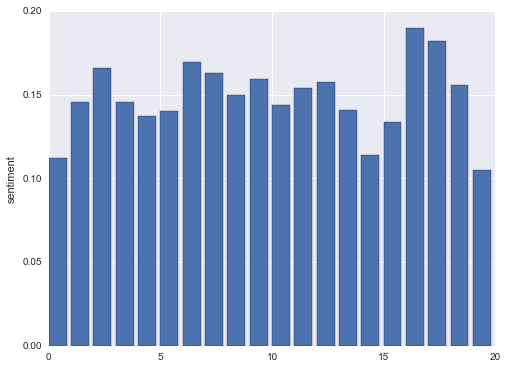

In [77]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [78]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
7570,At the third time I shall suck thy breasts wit...,"[2, 3, 5, 4, 1, 5, 4, 3, 7, 4, 4, 7, 4, 3, 4, ...",159,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, ...",52,-0.025,8,1,2,0
7571,"That will last until half-past two o'clock, th...","[4, 4, 4, 5, 9, 3, 7, 4, 2, 5, 5, 8, 4, 5, 5, ...",153,"[1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, ...",47,0.000,8,1,0,0
7572,"Behold, the following part shall come to you i...","[6, 3, 9, 4, 5, 4, 2, 3, 2, 3, 12, 7, 3]",63,"[2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1]",20,0.000,6,0,0,4
7573,Mem.,[3],3,[1],1,0.000,1,0,0,4
7574,"The commission herein is returnable in Paris, ...","[3, 10, 6, 2, 10, 2, 5, 4, 4, 4]",50,"[1, 3, 2, 1, 3, 1, 2, 0, 1, 0]",14,0.000,6,0,0,4


In [79]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) - (.06 * (int(len(df_novel) - 1)))
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [80]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(0, 3):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:2561]
df_novel['total_char'][2561:5103]
df_novel['total_char'][5103:7564]


In [81]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
2561
0.141690336057
2561
5103
0.156835186166
5103
7564
0.143076556235


In [82]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.14169034  0.15683519  0.14307656]


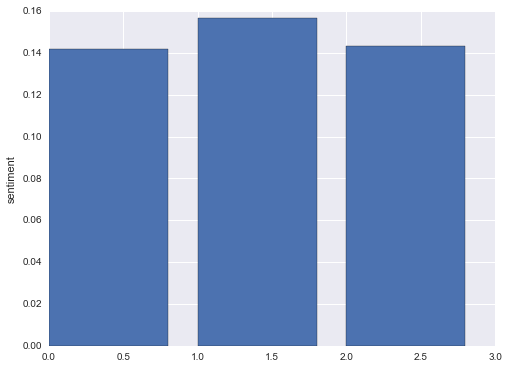

In [83]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers